In [1]:
import datetime
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from astropy.time import Time
from astropy import units as u
from astropy.coordinates import solar_system_ephemeris,get_body_barycentric

import cairo
import IPython.display


In [2]:
solar_system_ephemeris.set('de438.bsp')

<ScienceState solar_system_ephemeris: 'de438.bsp'>

In [3]:
time_now = Time(datetime.datetime.utcnow(), scale='utc')
positions=[]
body_ignore=['earth-moon-barycenter','pluto']
for body in solar_system_ephemeris.bodies:
    if body in body_ignore:
        continue
    pos = get_body_barycentric(body, time_now).xyz.to(u.au)
    positions.append(pos.value)
    
positions=np.array(positions)

In [4]:
def svd_plane_normal(points):
    # matrix should be in shape:
    #[[x],
    # [y],
    # [z]]

    u,s,vh = np.linalg.svd(points)
    normal = u[:,2]

    return normal

def plane(coords,normal):
    x,y = coords
    return -(normal[0]*x + normal[1]*y)/normal[2]

In [5]:
def centroid(positions):
    return np.sum(positions,axis=0)/positions.shape[0]

In [6]:
points = np.transpose(positions-centroid(positions))
normal = svd_plane_normal(points)

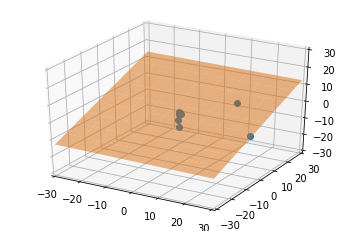

In [7]:
x = np.linspace(-30,30,10)
y = np.linspace(-30,30,10)

X,Y = np.meshgrid(x,y)
Z = plane((X,Y),normal)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(*zip(*positions),linestyle='none',marker='o')
ax.plot_surface(X, Y, Z, alpha=0.5)
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_zlim(-30,30)
plt.show()

In [8]:
a = normal
b = np.array([1,0,plane((1,0),normal)])
c = b/np.linalg.norm(b)
b = np.cross(a,b)

coord_transform = np.vstack([c,b,a])

In [9]:
new_points = []
for row in np.transpose(points):
    new_points.append(np.dot(coord_transform,row+centroid(positions)))

new_points = np.array(new_points)

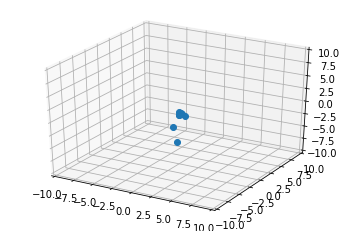

In [10]:
x = np.linspace(-30,30,10)
y = np.linspace(-30,30,10)

X,Y = np.meshgrid(x,y)
Z = plane((X,Y),normal)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(*zip(*new_points),linestyle='none',marker='o')
#ax.plot_surface(X, Y, Z, alpha=0.5)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)
plt.show()

In [11]:
def cart_to_polar(x, y, z):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi, z)

def polar_to_cart(rho, phi, z):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y, z)

In [12]:
polars=[]
for row in new_points:
    polars.append(cart_to_polar(*row))
    
polars = np.array(polars)

In [13]:
np.flip(polars[:,0:2],axis=1)

array([[ 2.24988947e+00,  8.73367988e-03],
       [-3.20243033e-01,  3.71347751e-01],
       [-5.94997982e-01,  7.19240985e-01],
       [-1.09914864e+00,  1.00777957e+00],
       [-1.09831582e+00,  1.00535424e+00],
       [-5.75578427e-01,  1.37465313e+00],
       [-1.17174848e+00,  5.14650052e+00],
       [-1.06959818e+00,  1.00034349e+01],
       [ 6.57984381e-01,  1.97946069e+01],
       [-1.85634150e-01,  2.99232138e+01]])

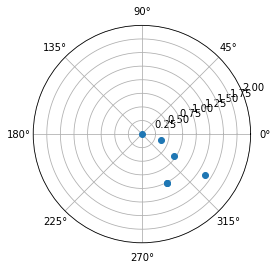

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

ax.plot(*zip(*np.flip(polars[:,0:2],axis=1)[0:6]),marker='o',linestyle='none')
ax.set_rlim(0,2)
plt.show()

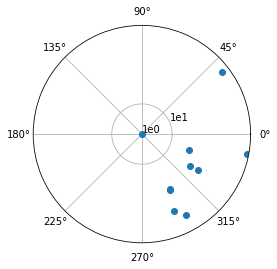

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')

theta,r = zip(*np.flip(polars[:,0:2],axis=1))


min_log = np.log10(np.min(r))
max_log = np.log10(np.max(r))
max_log = np.log10(35)
r_log = np.log10(r) - min_log


ax.plot(theta,r_log,marker='o',linestyle='none')

l = np.arange(np.floor(min_log), max_log)

ax.set_rticks(l)
ax.set_yticklabels(["1e%d" % x for x in l])
ax.set_rlim(0, max_log - min_log)

plt.show()

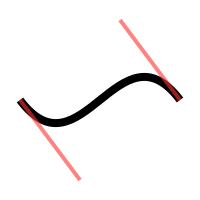

In [16]:
svgio = BytesIO()
with cairo.SVGSurface(svgio, 200, 200) as surface:

    context = cairo.Context(surface)
    x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
    x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
    context.scale(200, 200)
    context.set_line_width(0.04)
    context.move_to(x, y)
    context.curve_to(x1, y1, x2, y2, x3, y3)
    context.stroke()
    context.set_source_rgba(1, 0.2, 0.2, 0.6)
    context.set_line_width(0.02)
    context.move_to(x, y)
    context.line_to(x1, y1)
    context.move_to(x2, y2)
    context.line_to(x3, y3)
    context.stroke()

IPython.display.SVG(data=svgio.getvalue())